# Step 1: Create a dataset

In [ ]:
from llm_trainer import create_dataset

create_dataset(save_dir="data",           # Safe files to "data/"
               dataset="fineweb-edu-10B", # Use this dataset: https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu
               chunk_limit=50,           # Create 50 .npy files
               chunk_size=int(1e6))       # Each file will contain 1M tokens

Resolving data files:   0%|          | 0/2110 [00:00<?, ?it/s]

Processing Chunks: 100%|██████████| 50/50 [00:28<00:00,  1.78chunk/s]


# Step 2: Define GPT-2 model

In [2]:
from transformers import GPT2LMHeadModel, GPT2Config
import tiktoken

gpt2_config = GPT2Config(
    vocab_size=50257,
    n_positions=512,
    n_embd=512,
    n_layer=8,
    n_head=8,
)

gpt2_model = GPT2LMHeadModel(gpt2_config)
tokenizer = tiktoken.get_encoding("gpt2")

# Print the size of the model (a number of parameters it has) in millions.
num_params = sum(p.numel() for p in gpt2_model.parameters() if p.requires_grad)
print(f"Total Parameters: {num_params / 1e6:.2f}M")

Total Parameters: 51.21M


# Step 3: Create an LLMTrainer object

In [3]:
from llm_trainer import LLMTrainer

trainer = LLMTrainer(model=gpt2_model,
                    optimizer=None,       # defaults to AdamW with weights decay.
                    scheduler=None,       # defaults to Warm-up steps + Cosine Annealing.
                    tokenizer=tokenizer,  # GPT2 tokenizer (this is also a choice by default).
                    )

# Step 4: Start training

In [4]:
trainer.train(max_steps=1_000,                      # Do 1_000 optimization steps.
                generate_each_n_steps=100,          # Sample from the model each 100 steps (and print it).
                print_logs_each_n_steps=10,        # Print [step, loss, norm, lr, dt, tok/sec] every 100 steps.
                context_window=256,                 # Context window (The maximum sequence length that this model might ever be used with).
                data_dir="data",                    # Directory with .npy files containing tokens.
                BATCH_SIZE=512,                     # Batch size.
                MINI_BATCH_SIZE=16,                 # Gradient accumulation is used. BATCH_SIZE = MINI_BATCH_SIZE * accumulation_steps.
                logging_file="logs_training.csv",   # File to write the training logs.
                save_each_n_steps=1_000,            # Save the state each 1000 steps.
                save_dir="checkpoints",             # Directory where to save training state (model + optimizer + dataloader).
                prompt="Once upon a time in Russia" # The model will continue this prompt each `generate_each_n_steps` steps.
)

step: 0 | Loss: 10.687500 | norm: 7.3973 | lr: 2.000000e-05 | dt: 7.34s | tok/sec: 17854.96
step: 10 | Loss: 9.937500 | norm: 2.0822 | lr: 8.666667e-05 | dt: 2.40s | tok/sec: 54642.17
step: 20 | Loss: 9.187500 | norm: 2.0336 | lr: 1.533333e-04 | dt: 2.43s | tok/sec: 53997.94
step: 30 | Loss: 8.250000 | norm: 1.4926 | lr: 2.200000e-04 | dt: 2.37s | tok/sec: 55402.10
step: 40 | Loss: 7.812500 | norm: 0.9694 | lr: 2.866667e-04 | dt: 2.35s | tok/sec: 55794.65
step: 50 | Loss: 7.437500 | norm: 0.7283 | lr: 3.533333e-04 | dt: 2.32s | tok/sec: 56391.04
step: 60 | Loss: 7.218750 | norm: 0.9472 | lr: 4.200000e-04 | dt: 2.34s | tok/sec: 55917.91
step: 70 | Loss: 7.187500 | norm: 0.9489 | lr: 4.866667e-04 | dt: 2.37s | tok/sec: 55371.35
step: 80 | Loss: 7.031250 | norm: 0.5371 | lr: 5.533333e-04 | dt: 2.37s | tok/sec: 55364.31
step: 90 | Loss: 6.906250 | norm: 0.7248 | lr: 6.200000e-04 | dt: 2.31s | tok/sec: 56697.42


W0309 17:01:51.030000 42921 site-packages/torch/_inductor/utils.py:1137] [0/1] Not enough SMs to use max_autotune_gemm mode


=== sample 0 ===
Once upon a time in Russia of the first the number of the U of order to look. The time that was to change. The year of the food.
=== sample 1 ===
Once upon a time in Russia in which was a person to the public.
-level and others the person; the way.
The first of the time
=== sample 2 ===
Once upon a time in Russia.<|endoftext|>What” is a new year of the following example that they not become your number of “We were more of
=== sample 3 ===
Once upon a time in Russia. In people, I did’d.
The current, and is often to the other group.
2. So
step: 100 | Loss: 6.625000 | norm: 1.2674 | lr: 6.866667e-04 | dt: 31.02s | tok/sec: 4224.87
step: 110 | Loss: 6.625000 | norm: 1.0641 | lr: 7.533333e-04 | dt: 2.36s | tok/sec: 55494.79
step: 120 | Loss: 6.718750 | norm: 1.1583 | lr: 8.200000e-04 | dt: 2.37s | tok/sec: 55413.37
step: 130 | Loss: 6.718750 | norm: 0.9386 | lr: 8.866667e-04 | dt: 2.31s | tok/sec: 56737.85
step: 140 | Loss: 6.281250 | norm: 0.7116 | lr: 9.533333e-04 | dt: 4

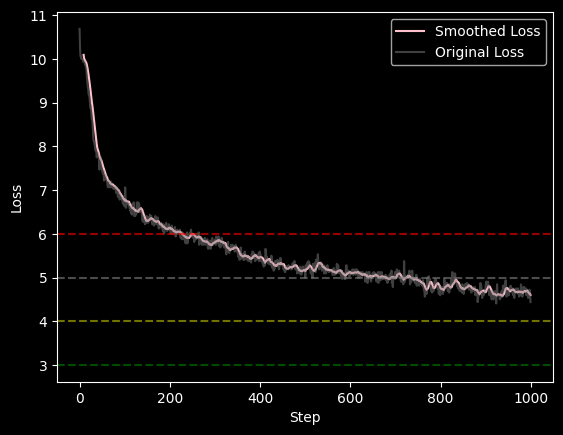

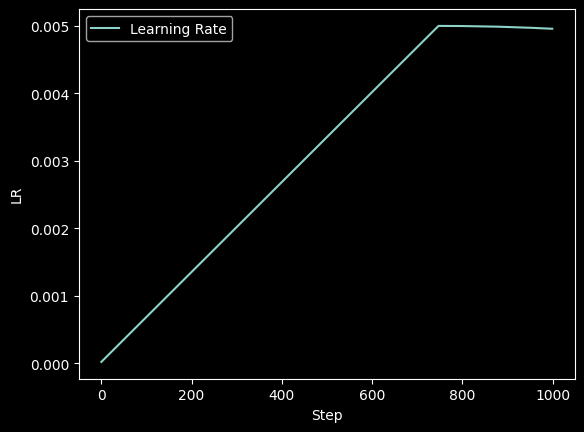

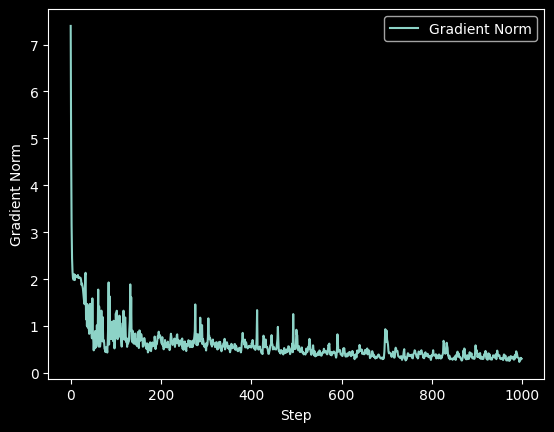

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# DISPLAY LOSS
data = pd.read_csv("logs_training.csv")

window_size = 10  # Adjust for more or less smoothing
smoothed_loss = data["Loss"].rolling(window=window_size).mean()

plt.plot(data["Step"], smoothed_loss, label="Smoothed Loss", color="pink")
plt.plot(data["Step"], data["Loss"], alpha=0.5, label="Original Loss", color="gray")

plt.axhline(y=6, color='r', linestyle='--', alpha=0.6)
plt.axhline(y=5, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=4, color='y', linestyle='--', alpha=0.6)
plt.axhline(y=3, color='g', linestyle='--', alpha=0.6)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# DISPLAY LEARNING RATE
plt.plot(data["Step"], data["LR"], label="Learning Rate")
plt.xlabel("Step")
plt.ylabel("LR")
plt.legend()
plt.show()

# DISPLAY GRADIENT NORM
plt.plot(data["Step"], data["Norm"], label="Gradient Norm")
plt.xlabel("Step")
plt.ylabel("Gradient Norm")
plt.legend()
plt.show()